In [63]:
from google.colab import files 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

from tensorflow.keras import utils 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import plot_model

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances


In [3]:
df = pd.read_csv('/content/train.csv')
df.head(2)

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,Тип переклассификации,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место
0,Тест,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 07:42,2018-01-19 09:27,Запрос,Запрос,Тест,0,NaN,2018-01-19 09:43,4-Нет,3-Малое,База,К
1,Тестовое обращение,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 10:51,2018-01-19 09:36,Запрос,Запрос,Тест,0,NaN,2018-01-19 09:41,4-Нет,3-Малое,База,К


In [15]:
uniques = pd.unique(df[['Тип обращения итоговый']].values.ravel ())
uniques

array(['Запрос', 'Инцидент'], dtype=object)

Преобразуем тексты обращений в ембеддинги

In [7]:
texts = df['Содержание'].values
texts = texts.astype(str)
maxWordsCount = 10000 
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(texts) 


xTrain = tokenizer.texts_to_matrix(texts) 
print(xTrain.shape) 
print(xTrain[2, :20])

(14803, 10000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [18]:
print(tokenizer.word_index.items()) #Вытаскиваем индексы слов для просмотра

dict_items([('unknown', 1), ('заявка', 2), ('на', 3), ('к', 4), ('предоставление', 5), ('доступа', 6), ('прав', 7), ('и', 8), ('ресурсам', 9), ('отзыв', 10), ('настройка', 11), ('№', 12), ('в', 13), ('письмо', 14), ('записи', 15), ('пользователя', 16), ('разблокировка', 17), ('консультация', 18), ('доступ', 19), ('техническое', 20), ('обслуживание', 21), ('учетной', 22), ('портам', 23), ('контроль', 24), ('пу', 25), ('запрос', 26), ('для', 27), ('по', 28), ('создание', 29), ('изменение', 30), ('сервис22', 31), ('эп', 32), ('бот', 33), ('наблюдения', 34), ('ресурсу', 35), ('ухудшение', 36), ('статуса', 37), ('сервиса', 38), ('boss', 39), ('не', 40), ('разблокировать', 41), ('сервисы', 42), ('уз', 43), ('ремонт', 44), ('система21', 45), ('работ', 46), ('система13', 47), ('логического', 48), ('брм', 49), ('замена', 50), ('запись', 51), ('система7', 52), ('выполнена', 53), ('учетную', 54), ('учётной', 55), ('region', 56), ('сертификат', 57), ('транспортный', 58), ('шлюз', 59), ('пользовате

In [50]:
trainWordIndexes = tokenizer.texts_to_sequences(texts)

In [51]:
longest = len(max(trainWordIndexes, key=len))
for i in trainWordIndexes:
    if len(i) < longest:
        i.extend([0]*(longest-len(i)))

In [52]:
trainWordIndexes = np.asarray(trainWordIndexes)
trainWordIndexes.shape

(14803, 15)

##Классификация запрос-инцидент

Преобразуем название класса в цифровой тип, 
0 - запрос
1 - Инцидент

In [5]:
classes = df['Тип обращения итоговый'].values
for i in range(classes.shape[0]):
  if classes[i] == 'Запрос':
    classes[i] = 0.0
  if classes[i] == 'Инцидент':
    classes[i] = 1.0
classes = [float(i) for i in classes]
classes = np.asarray(classes)

In [31]:
model1 = Sequential()
model1.add(Dense(400, input_dim = maxWordsCount, activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(600, activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(200, activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(1, activation='linear'))

model1.compile(optimizer=Adam(learning_rate=0.001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])



Epoch 1/20
93/93 [==============================] - 16s 147ms/step - loss: 0.3901 - accuracy: 0.9746 - val_loss: 0.5418 - val_accuracy: 0.9649
Epoch 2/20
93/93 [==============================] - 13s 139ms/step - loss: 0.3921 - accuracy: 0.9746 - val_loss: 0.5418 - val_accuracy: 0.9649
Epoch 3/20
93/93 [==============================] - 9s 100ms/step - loss: 0.3921 - accuracy: 0.9746 - val_loss: 0.5418 - val_accuracy: 0.9649
Epoch 4/20
93/93 [==============================] - 12s 129ms/step - loss: 0.3921 - accuracy: 0.9746 - val_loss: 0.5418 - val_accuracy: 0.9649
Epoch 5/20
93/93 [==============================] - 12s 131ms/step - loss: 0.3921 - accuracy: 0.9746 - val_loss: 0.5418 - val_accuracy: 0.9649
Epoch 6/20
93/93 [==============================] - 20s 211ms/step - loss: 0.3921 - accuracy: 0.9746 - val_loss: 0.5418 - val_accuracy: 0.9649
Epoch 7/20
93/93 [==============================] - 16s 170ms/step - loss: 0.3921 - accuracy: 0.9746 - val_loss: 0.5418 - val_accuracy: 0.9649


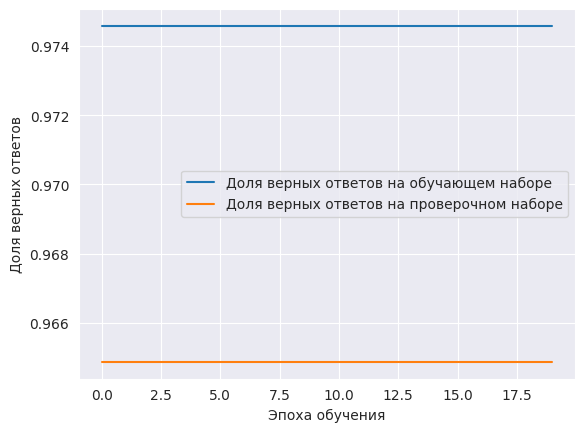

In [33]:
#Обучаем сеть на выборке
history = model1.fit(xTrain, 
                    classes, 
                    epochs=20,
                    batch_size=128,
                    validation_split = 0.2)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

проверим на тестовом наборе

In [27]:
test_df = pd.read_csv('/content/test.csv')


In [28]:
test_texts = test_df['Содержание'].values
test_texts = test_texts.astype(str)
xTest = tokenizer.texts_to_matrix(test_texts) 
print(xTest.shape) 
print(xTest[2, :20])

(6344, 10000)
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [45]:
currPred = model1.predict(xTest)


199/199 [==============================] - 3s 17ms/step


In [47]:
test_df['Содержание'][2]

'Заявка на предоставление и отзыв прав доступа к ресурсам'

In [48]:
if currPred[2] <0.5:
  print('Запрос')
else:
  print('Инцидент')


Запрос


##Кластеризация обращений

In [61]:
def find_k(matrix):
    k_min = 8
    clst = [x for x in range(2, k_min * 11)]
    metrics = []
    for i in clst:
        metrics.append((KMeans(n_clusters=i).fit(matrix)).inertia_)
    k = mean(k_min, clst, metrics)
    return k

In [62]:

def mean(k_min, clst, metrics):
    score = []

    for i in range(k_min, clst[-3]):
        y1 = np.array(metrics)[:i + 1]
        y2 = np.array(metrics)[i:]
    
        df1 = pd.DataFrame({'x': clst[:i + 1], 'y': y1})
        df2 = pd.DataFrame({'x': clst[i:], 'y': y2})
    
        reg1 = LinearRegression().fit(np.asarray(df1.x).reshape(-1, 1), df1.y)
        reg2 = LinearRegression().fit(np.asarray(df2.x).reshape(-1, 1), df2.y)

        y1_pred = reg1.predict(np.asarray(df1.x).reshape(-1, 1))
        y2_pred = reg2.predict(np.asarray(df2.x).reshape(-1, 1))    
        
        score.append(mean_squared_error(y1, y1_pred) + mean_squared_error(y2, y2_pred))

    return np.argmin(score) + k_min

k = find_k(trainWordIndexes)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Самые близкие к центру кластеров тексты

In [ ]:
kmeans = KMeans(n_clusters = k, random_state = 42).fit(trainWordIndexes)
kmeans_labels = kmeans.labels_

In [ ]:
clusted = pd.DataFrame()
clusted['text'] = texts
clusted['label'] = kmeans_labels
clusted['matrix'] = list(trainWordIndexes)

In [ ]:
kmeans_centers = kmeans.cluster_centers_
texts_list = []
for i in range (0, k):
    cluster = clusted[clusted['label'] == i]
    embeddings = list(cluster['matrix'])
    texts = list(cluster['text'])
    distances = [euclidean_distances(kmeans_centers[0].reshape(1, -1), e.reshape(1, -1))[0][0] for e in embeddings]
    scores = list(zip(texts, distances))
    best = sorted(scores, key=lambda x: x[1])[:3]
    texts = list(zip(*best))[0]
    texts_list.append(texts)

In [25]:
texts_list

[('Разблокировка учетной записи пользователя',
  'Настройка/Консультация /Техническое обслуживание',
  'Настройка/Консультация /Техническое обслуживание'),
 ('ремонт розетки', 'Ремонт розетки', ' Перемещение грузов.'),
 ('Ремонт выдвижного ящика тумбы подкатной',
  'Ремонт выдвижного ящика тумбы подкатной',
  'разгрузка машины и перемещение  (диски)'),
 ('<Бот-наблюдения> Система203. Ухудшение статуса сервиса.  ',
  '<Бот-наблюдения> Система203. Ухудшение статуса сервиса.  ',
  '<Бот-наблюдения> Система330. Ухудшение статуса сервиса.  '),
 ('Консультация или решение проблем связанных с сервисами Система13',
  'Консультация или решение проблем связанных с сервисами Система13',
  'Консультация или решение проблем связанных с сервисами Система13'),
 ('В приложение "Система20" нет возможности работы с файлами. Многочисленные обращения пользователей.',
  'Закрепить дозатор для освежителя воздуха в с/узл',
  'Закрепить дозатор для освежителя воздуха в с/узле'),
 ('- ввести ПК в домен',
  'Те

In [23]:
clusted.head(80)

,text,label,embedding
0,Тест,0,"[282, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Тестовое обращение,6,"[914, 638, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Выполнена разблокировка у/з REGION\*****,0,"[56, 17, 67, 69, 54, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,.Не включается ПК,9,"[41, 538, 77, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"Заявка № ***********, *******************",0,"[2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...
75,"Заявка № ***********, *******************",0,"[2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
76,"Заявка № ***********, *******************",0,"[2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
77,"Заявка № ***********, *******************",0,"[2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
78,"Заявка № ***********, *******************",0,"[2, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
